<a href="https://colab.research.google.com/github/2303A51674/NLP/blob/main/NLP_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import re
import nltk
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
zip_path = "tweets.csv.zip"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./")

df = pd.read_csv("tweets.csv")

In [ ]:
print("\n--- Dataset Info ---")
print(df.info())
print(df.head())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB
None
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings 

In [ ]:
class_counts = df['target'].value_counts()
print("\n--- Class Counts ---")
print(class_counts)


--- Class Counts ---
target
0    9256
1    2114
Name: count, dtype: int64


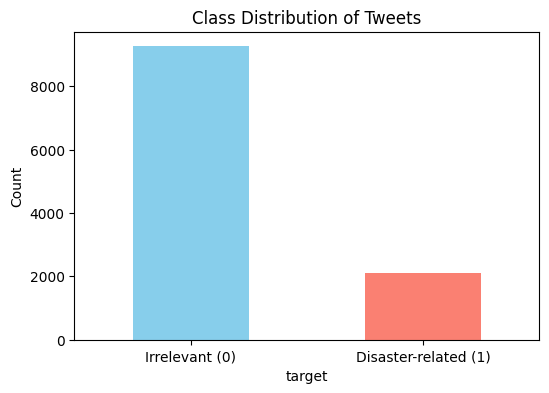

In [ ]:
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['skyblue','salmon'])
plt.xticks([0,1], ['Irrelevant (0)', 'Disaster-related (1)'], rotation=0)
plt.title("Class Distribution of Tweets")
plt.ylabel("Count")
plt.show()

In [ ]:
print("\n--- Example Disaster Tweets ---")
print(df[df['target']==1]['text'].sample(3, random_state=42).to_list())

print("\n--- Example Irrelevant Tweets ---")
print(df[df['target']==0]['text'].sample(3, random_state=42).to_list())


--- Example Disaster Tweets ---
['#StormBrendan Update-8.00 Tuesday.: Significant overtopping around high tide on Monday evening led to closure of Prom. Wa…', "British politicians are quick to call Israel an 'ally'. Yet when Britain was at war with Argentina, Israel was busy selli…", '1033) British Model Madalyn Davis dies in Sydney cliff fall. https://t.co/EZaWxVWY4y']

--- Example Irrelevant Tweets ---
['s 1656ABAF :Battle ID I need backup! Lvl 100 Colossus Omega https://t.co/YeOnr59F9Z', 'The place where these children once called home is no more after being bombed by #Assad and #Putin. We are so lucky they are…', 'i ordered one from @/wonu_hurricane ! good luck sis ~ https://t.co/Bm5CmpFREq']


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions & hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove emojis / non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords & punctuation
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    # Handle elongated words (soooo → soo)
    tokens = [re.sub(r'(.)\1{2,}', r'\1\1', t) for t in tokens]
    return tokens

In [ ]:
##Stemming vs Lemmatization
example_tweets = df['text'].sample(5, random_state=0).tolist()
results = []
for tweet in example_tweets:
    tokens = clean_text(tweet)
    stemmed = [stemmer.stem(t) for t in tokens]
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    results.append([tweet, " ".join(stemmed), " ".join(lemmatized)])

df_results = pd.DataFrame(results, columns=["Original", "Stemmed", "Lemmatized"])
print("\n--- Stemming vs Lemmatization ---")
print(df_results.to_string(index=False))


--- Stemming vs Lemmatization ---
                                                                                                                  Original                                                                  Stemmed                                                                     Lemmatized
The strange lack of any follow up on Pulwama by the authorities and/or the press confirms my fears that someone was put u… strang lack follow pulwama author and/or press confirm fear someon put u strange lack follow pulwama authority and/or press confirms fear someone put u
   Hongbin replied to a comment on his recent video ☆ I miss you Hongbin: I'm not dead;; I'm wheezing😂😂😂😂😂 https://t.co/4…         hongbin repli comment recent video miss hongbin 'm dead 'm wheez          hongbin replied comment recent video miss hongbin 'm dead 'm wheezing
                                                        If you see rioting bhakts smash window panes, blame Satya Nadella.                  

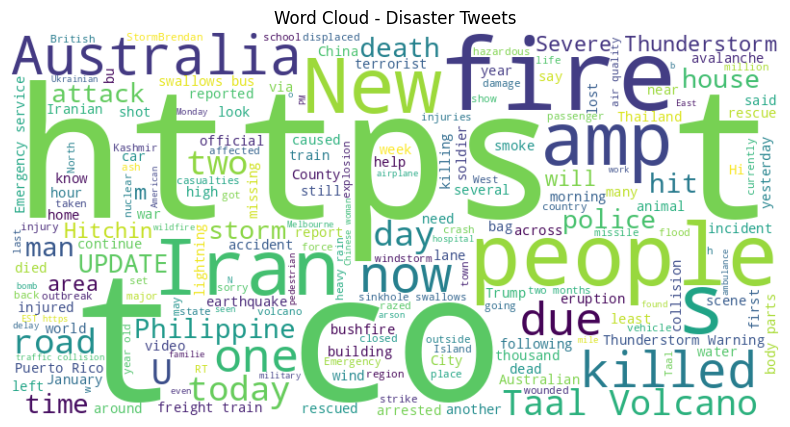

In [ ]:
disaster_text = " ".join(df[df['target']==1]['text'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Disaster Tweets")
plt.show()

/tmp/ipython-input-2337450045.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Bigram", data=bigram_df, palette="viridis")


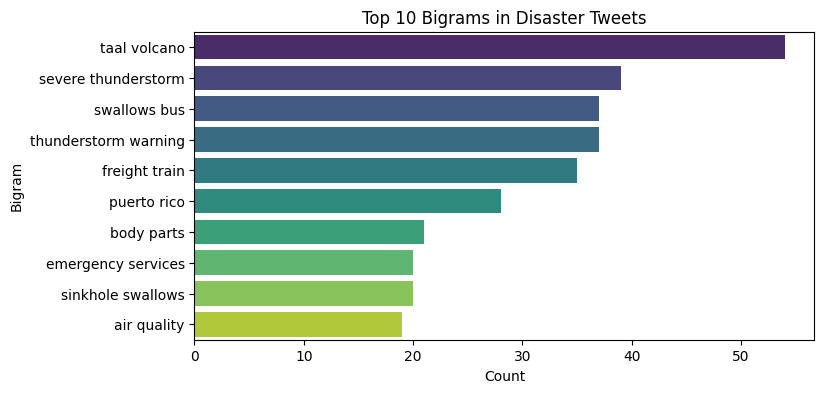

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english")
X_bigrams = vectorizer.fit_transform(df[df['target']==1]['text'])
bigrams_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X_bigrams.sum(axis=0).A1)))
top_bigrams = bigrams_counts.most_common(10)

bigram_df = pd.DataFrame(top_bigrams, columns=["Bigram","Count"])
plt.figure(figsize=(8,4))
sns.barplot(x="Count", y="Bigram", data=bigram_df, palette="viridis")
plt.title("Top 10 Bigrams in Disaster Tweets")
plt.show()

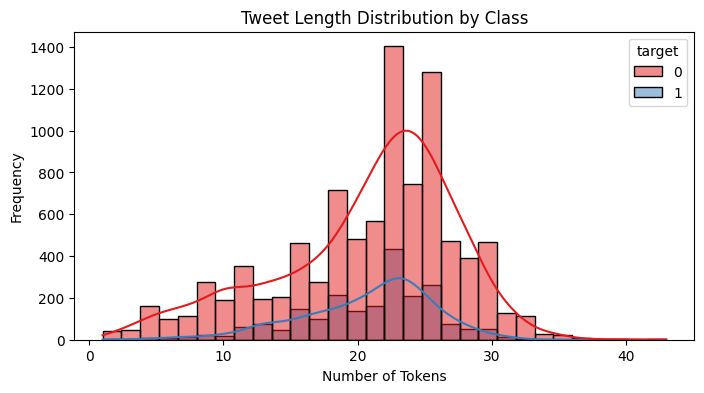

In [ ]:
df["length"] = df["text"].apply(lambda x: len(word_tokenize(str(x))))
plt.figure(figsize=(8,4))
sns.histplot(data=df, x="length", hue="target", bins=30, kde=True, palette="Set1")
plt.title("Tweet Length Distribution by Class")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Q6: TF-IDF
tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X = tfidf.fit_transform(df['text'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Naive Bayes": MultinomialNB()
}

In [ ]:
model_scores = {}
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    model_scores[name] = classification_report(y_test, y_pred, output_dict=True)


--- Training Logistic Regression ---
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1851
           1       0.89      0.37      0.52       423

    accuracy                           0.87      2274
   macro avg       0.88      0.68      0.72      2274
weighted avg       0.88      0.87      0.85      2274


--- Training Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1851
           1       0.85      0.44      0.58       423

    accuracy                           0.88      2274
   macro avg       0.87      0.71      0.76      2274
weighted avg       0.88      0.88      0.87      2274


--- Training Naive Bayes ---
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1851
           1       0.85      0.42      0.56       423

    accuracy                           0.88      2274
   macro avg       0.87     

In [ ]:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

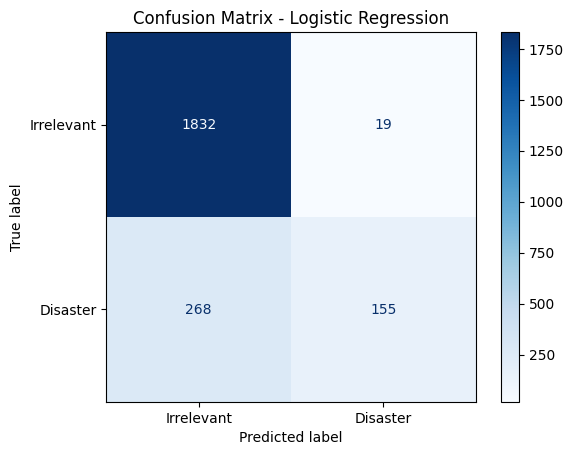

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Irrelevant","Disaster"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()